In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
#caluclating fft
def calcfftandplot(data,colname='rainfall'):
    x = data['Date']
    y = data[colname]
    fft_y = np.fft.fft(y)
    fft_y_ = np.abs(fft_y)
    fft_y_power = np.abs(fft_y_)**2

    #1/120 coz its month
    freq = np.fft.fftfreq(len(x),1/120)
    plt.rcParams['figure.figsize'] = (15, 6)
    plt.rcParams['axes.xmargin'] = 0.1
    plt.plot(freq,fft_y_power,'green')

    plt.xlabel('Freq')
    plt.ylabel('Amplitude/power')
    plt.title('fft of the rainfall')
    
    plt.show()
    print(fft_y_power.shape)
    print(fft_y_power[-1])
    return fft_y,freq

#removing the lower frequency
def plotforlowerfreq(fft_y,time,data,freq,colname='rainfall'):
    # peak1 -> 2000000000
    # peak2 -> 1200000000
    # peak3 -> 500000000
    # peak4 -> 300000000
    # lpeak4 -> 10000000
    threshold = 10000000
    newarr = []
    newfft = np.array([])
    for a in range(len(fft_y)):
        temp = abs(fft_y[a].real)**2
        tempfft = fft_y[a]
        if temp > threshold:
            temp = 0
            tempfft = 0 + 0j

        newarr.append(temp)
        newfft = np.append(newfft,tempfft)
    
    plt.xlabel('harmonics')
    plt.ylabel('Amplitude/power')
    plt.title('fft of the rainfall (with high frequency removed)')    
    plt.plot(freq,np.abs(newfft.real)**2);
    plt.show();
    newifft = np.fft.ifft(newfft)
    ifft_y = np.fft.ifft(fft_y)
    
    plt.xlabel('Time')
    plt.ylabel('Rainfall (mm)')
    plt.title('Inverse FFT of Indian Rainfall (with high frequencies removed)')
    plt.plot(time,newifft.real,'red')
    plt.plot(time,ifft_y.real,'green')
    plt.plot(time,data[colname],'pink')
    plt.show()
    return newifft.real


#error for original rainfall
def calcerr(actual_values ,predicted_values):
    differences = actual_values - predicted_values
    squared_differences = np.square(differences)
    mean_squared_error = np.mean(squared_differences)
    return mean_squared_error

In [3]:
#data cleaning
df = pd.read_csv('./output2.csv')
df = df.drop(['Month','YEAR'],axis=1)
df['Date'] = pd.to_datetime(df['Date'])
newdf = df
df

,rainfall,Date
0,44.8,1905-01-01
1,20.8,1905-02-01
2,14.0,1905-03-01
3,1.3,1905-04-01
4,7.4,1905-05-01
...,...,...
1327,89.2,2015-08-01
1328,32.1,2015-09-01
1329,3.7,2015-10-01
1330,2.3,2015-11-01


In [4]:
#making , training , prediction 

df['previous_rainfall'] = df['rainfall'].shift()
df = df.dropna()
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]
X_train = train_data['previous_rainfall'].values.reshape(-1, 1)
y_train = train_data['rainfall'].values

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prepare the input variable for testing
X_test = test_data['previous_rainfall'].values.reshape(-1, 1)
dates = test_data['Date']  

# Make predictions for the test data
predictions = model.predict(X_test)

# Create a DataFrame to store the predictions with dates
predicted_df = pd.DataFrame({'Date': dates , 'Predicted Rainfall': predictions})

# Print the predicted rainfall values along with the dates
predicted_df['rainfall'] = test_data['rainfall']
predicted_df['previous_rainfall'] = test_data['previous_rainfall']
predicted_df

,Date,Predicted Rainfall,rainfall,previous_rainfall
1065,1993-10-01,80.581607,0.0,125.4
1066,1993-11-01,25.242138,0.0,0.0
1067,1993-12-01,25.242138,0.0,0.0
1068,1994-01-01,25.242138,20.1,0.0
1069,1994-02-01,34.112340,11.3,20.1
...,...,...,...,...
1327,2015-08-01,82.743994,89.2,130.3
1328,2015-09-01,64.606417,32.1,89.2
1329,2015-10-01,39.407983,3.7,32.1
1330,2015-11-01,26.874961,2.3,3.7


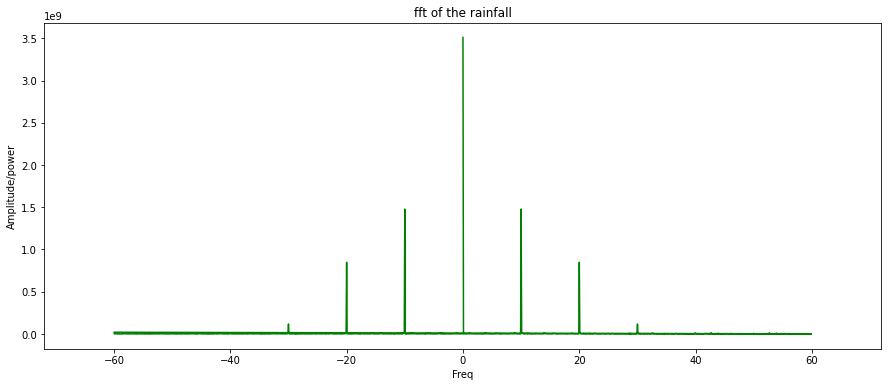

(1332,)
2303389.8495385502


,rainfall,Date,previous_rainfall
0,44.8,1905-01-01,NaN
1,20.8,1905-02-01,44.8
2,14.0,1905-03-01,20.8
3,1.3,1905-04-01,14.0
4,7.4,1905-05-01,1.3
...,...,...,...
1327,89.2,2015-08-01,130.3
1328,32.1,2015-09-01,89.2
1329,3.7,2015-10-01,32.1
1330,2.3,2015-11-01,3.7


In [5]:
fft_y,freq = calcfftandplot(newdf)
fft_y
newdf

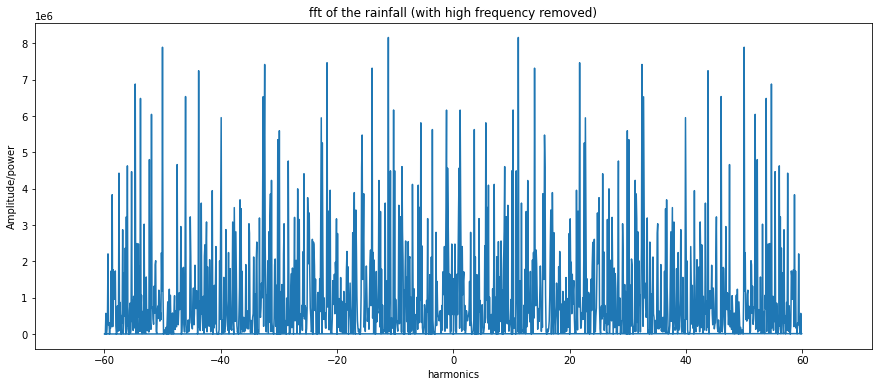

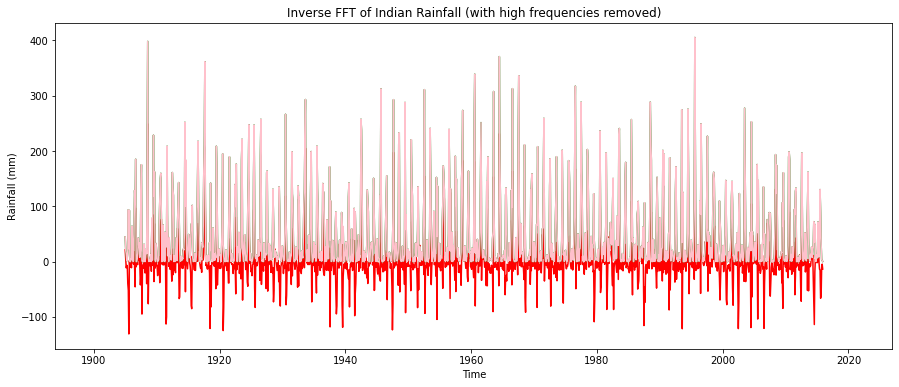

array([ 21.26524024,   4.43181427, -11.24068422, ..., -11.57990047,
        -4.5721779 , -13.51501   ])

In [6]:
newifft = plotforlowerfreq(fft_y,newdf['Date'],newdf,freq)
newifft

In [7]:
newdf['remove_peaks'] = newifft
newdf['previous_remove_peaks'] = newdf['remove_peaks'].shift()
newdf

,rainfall,Date,previous_rainfall,remove_peaks,previous_remove_peaks
0,44.8,1905-01-01,NaN,21.265240,NaN
1,20.8,1905-02-01,44.8,4.431814,21.265240
2,14.0,1905-03-01,20.8,-11.240684,4.431814
3,1.3,1905-04-01,14.0,-7.166510,-11.240684
4,7.4,1905-05-01,1.3,-7.034362,-7.166510
...,...,...,...,...,...
1327,89.2,2015-08-01,130.3,-66.308255,-14.811432
1328,32.1,2015-09-01,89.2,-62.216074,-66.308255
1329,3.7,2015-10-01,32.1,-11.579900,-62.216074
1330,2.3,2015-11-01,3.7,-4.572178,-11.579900


In [8]:
traindf = newdf[train_size:]
ddf = traindf[['Date','remove_peaks','previous_remove_peaks']]
x2_test = ddf['previous_remove_peaks'].values.reshape(-1, 1)

pred2 = model.predict(x2_test)

predicted_df2 = pd.DataFrame({'Date': ddf['Date'], 'Predicted Rainfall': pred2, 'ifft rainfall':ddf['remove_peaks'], 'prev ifft rainfall':ddf['previous_remove_peaks']})
predicted_df2 = predicted_df2.drop(index=1064)
predicted_df2

,Date,Predicted Rainfall,ifft rainfall,prev ifft rainfall
1065,1993-10-01,38.977210,-13.657800,31.123864
1066,1993-11-01,19.214901,-3.737542,-13.657800
1067,1993-12-01,23.592747,-9.202389,-3.737542
1068,1994-01-01,21.181090,2.262148,-9.202389
1069,1994-02-01,26.240432,1.568477,2.262148
...,...,...,...,...
1327,2015-08-01,18.705799,-66.308255,-14.811432
1328,2015-09-01,-4.019933,-62.216074,-66.308255
1329,2015-10-01,-2.214039,-11.579900,-62.216074
1330,2015-11-01,20.131886,-4.572178,-11.579900


In [9]:
predicted_df

,Date,Predicted Rainfall,rainfall,previous_rainfall
1065,1993-10-01,80.581607,0.0,125.4
1066,1993-11-01,25.242138,0.0,0.0
1067,1993-12-01,25.242138,0.0,0.0
1068,1994-01-01,25.242138,20.1,0.0
1069,1994-02-01,34.112340,11.3,20.1
...,...,...,...,...
1327,2015-08-01,82.743994,89.2,130.3
1328,2015-09-01,64.606417,32.1,89.2
1329,2015-10-01,39.407983,3.7,32.1
1330,2015-11-01,26.874961,2.3,3.7


In [10]:
print("MSE for original ->",calcerr(predicted_df['rainfall'],predicted_df['Predicted Rainfall']))
print("MSE for ifft rainfall ->",calcerr(predicted_df2['ifft rainfall'],predicted_df2['Predicted Rainfall']))

MSE for original -> 2948.4764579796006
MSE for ifft rainfall -> 2408.5574285571283


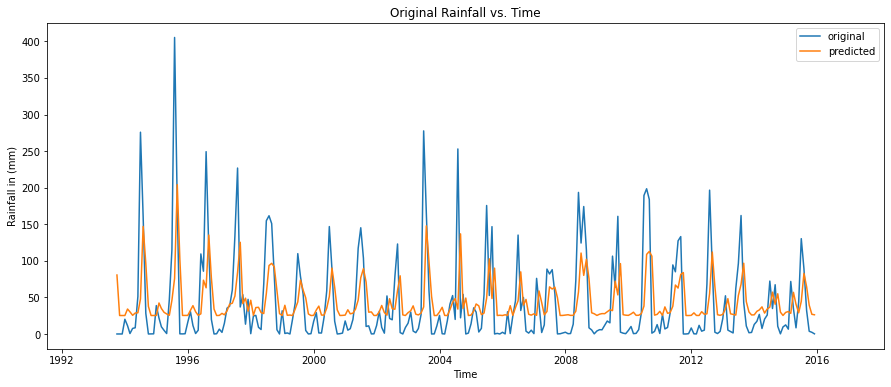

In [11]:
plt.xlabel('Time')
plt.ylabel('Rainfall in (mm)')
plt.title('Original Rainfall vs. Time')
plt.plot(predicted_df['Date'],predicted_df['rainfall'])
plt.plot(predicted_df['Date'],predicted_df['Predicted Rainfall'])
plt.legend(['original','predicted'])
plt.show()

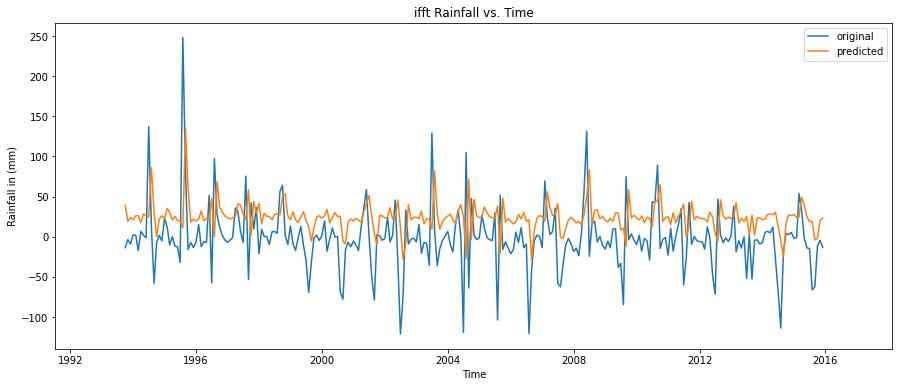

In [12]:
plt.xlabel('Time')
plt.ylabel('Rainfall in (mm)')
plt.title('ifft Rainfall vs. Time')
plt.plot(predicted_df2['Date'],predicted_df2['ifft rainfall'])
plt.plot(predicted_df2['Date'],predicted_df2['Predicted Rainfall'])
plt.legend(['original','predicted'])
plt.show()

In [13]:
train_pred = model.predict(X_train)
date = train_data['Date']
X_train

array([[ 44.8],
       [ 20.8],
       [ 14. ],
       ...,
       [ 42. ],
       [274.6],
       [ 35.6]])

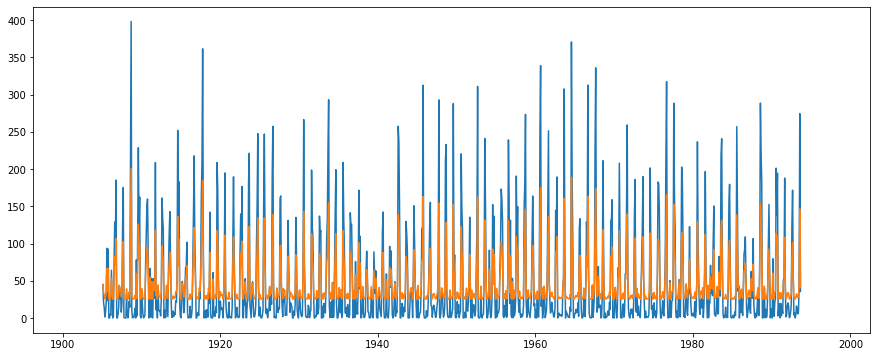

In [14]:
plt.plot(date,X_train)
plt.plot(date,train_pred)
plt.show()

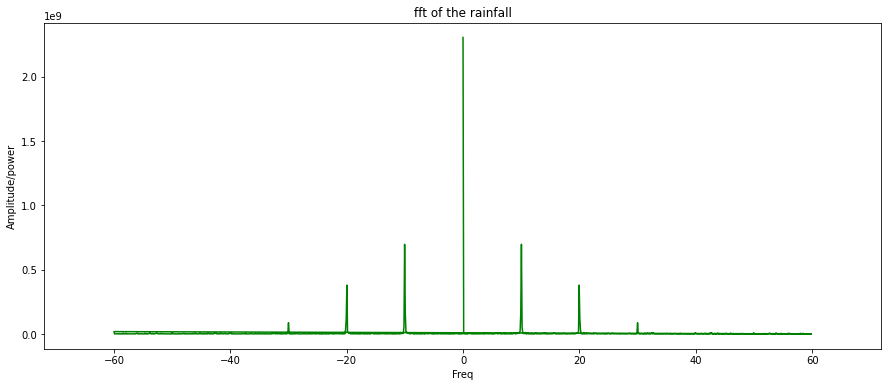

(1064,)
1919757.1607073883


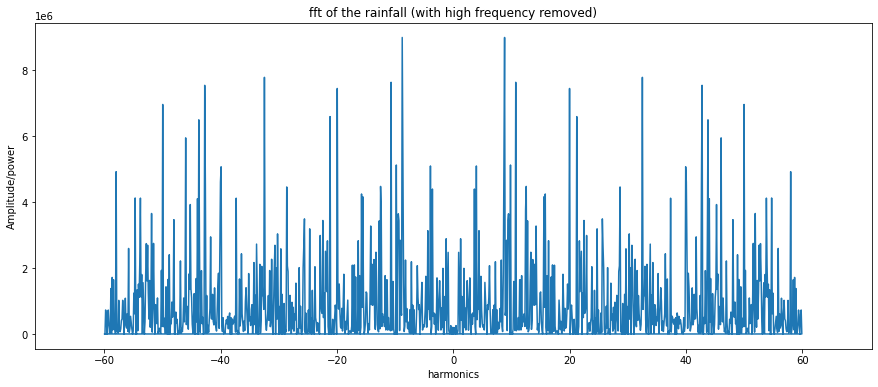

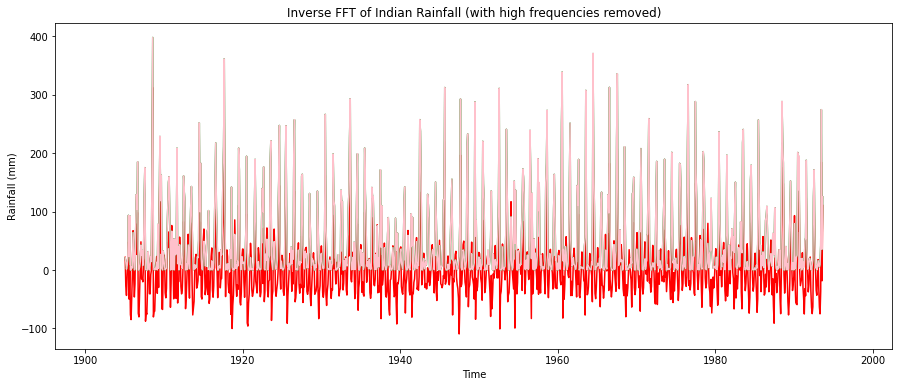

In [15]:
alphafft,alphafreq = calcfftandplot(train_data)
alphawithoutpeak = plotforlowerfreq(alphafft,train_data['Date'],train_data,alphafreq)

In [16]:
preddf = train_data
preddf["predicted"] = train_pred
preddf

<ipython-input-16-5f786db60a7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preddf["predicted"] = train_pred


,rainfall,Date,previous_rainfall,predicted
1,20.8,1905-02-01,44.8,45.012538
2,14.0,1905-03-01,20.8,34.421252
3,1.3,1905-04-01,14.0,31.420388
4,7.4,1905-05-01,1.3,25.815832
5,20.1,1905-06-01,7.4,28.507784
...,...,...,...,...
1060,8.8,1993-05-01,5.4,27.625177
1061,42.0,1993-06-01,8.8,29.125609
1062,274.6,1993-07-01,42.0,43.776888
1063,35.6,1993-08-01,274.6,146.424101


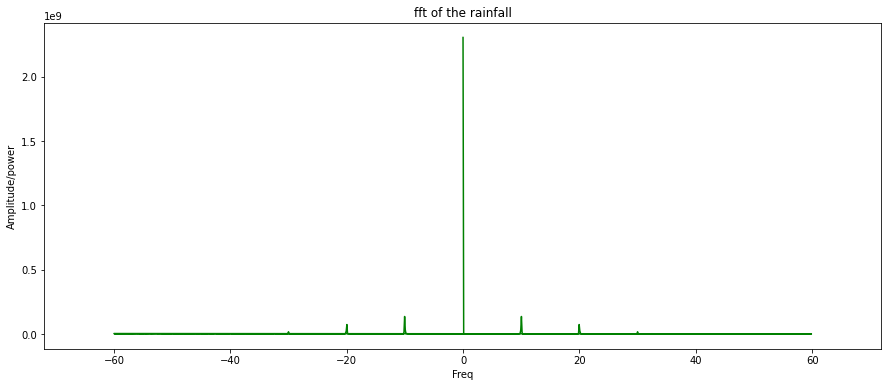

(1064,)
361054.6512970934


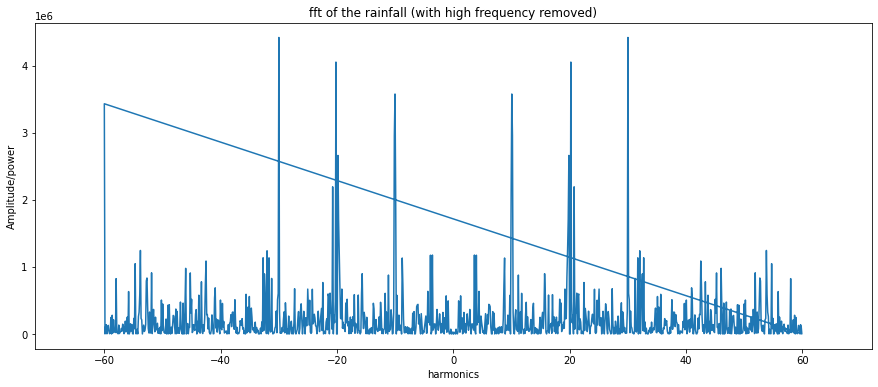

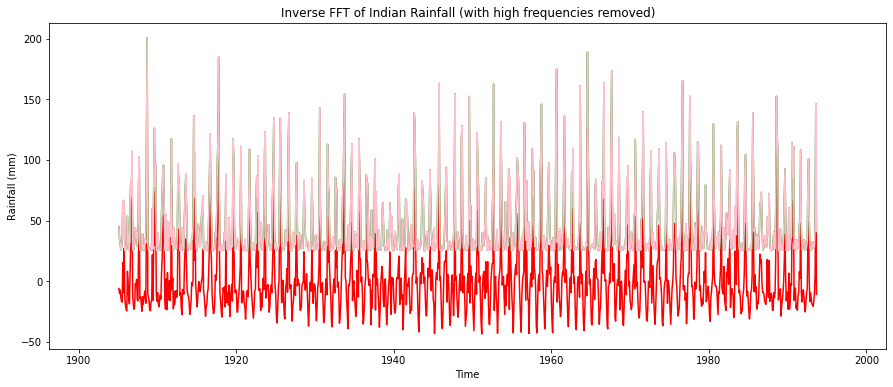

In [17]:
betafft,betafreq = calcfftandplot(train_data,'predicted')
betawithoutpeak = plotforlowerfreq(betafft,train_data['Date'],train_data,betafreq,'predicted')

In [18]:
betawithoutpeak

array([ -6.10927956, -10.22164327,  -7.24736326, ...,   4.59872863,
       100.62893385, -10.75857467])

In [19]:
alphawithoutpeak

array([ 21.7220559 , -27.62570138, -43.60024738, ..., 184.84600073,
       -18.5177854 , 110.43998546])

In [20]:
print("the error is ->",calcerr(betawithoutpeak,alphawithoutpeak))

the error is -> 3165.8150823771994


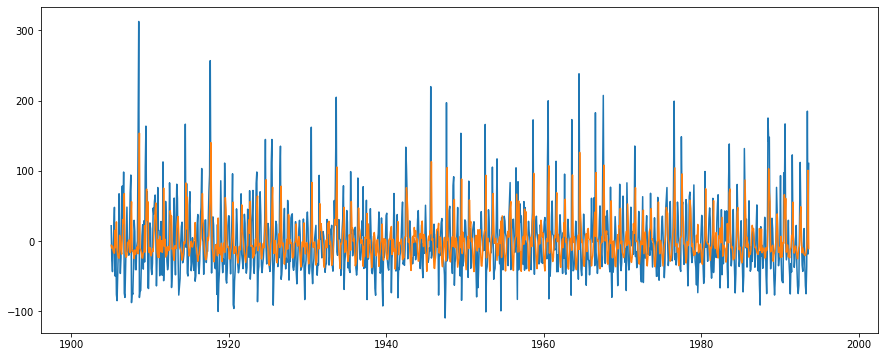

In [21]:
plt.plot(preddf['Date'],alphawithoutpeak)
plt.plot(preddf['Date'],betawithoutpeak)
plt.show()

In [24]:
calcerr(train_pred,train_data['rainfall'])

3727.6054356066506

In [22]:
train_data

,rainfall,Date,previous_rainfall,predicted
1,20.8,1905-02-01,44.8,45.012538
2,14.0,1905-03-01,20.8,34.421252
3,1.3,1905-04-01,14.0,31.420388
4,7.4,1905-05-01,1.3,25.815832
5,20.1,1905-06-01,7.4,28.507784
...,...,...,...,...
1060,8.8,1993-05-01,5.4,27.625177
1061,42.0,1993-06-01,8.8,29.125609
1062,274.6,1993-07-01,42.0,43.776888
1063,35.6,1993-08-01,274.6,146.424101


In [26]:
np.std(train_data['rainfall'])

68.02687162028258

In [28]:
np.std(alphawithoutpeak)

51.045993435483844